# Rating Your Moves: Demo

This notebook:
1. Evaluates a trained model on a held-out NPZ test shard (aggregate metrics)
2. Evaluates a single custom game from `gte.pgn`
3. Visualises per-move likelihoods / posteriors
4. Renders board + rating-distribution frames and stitches them into a replay

In [1]:
from pathlib import Path
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import chess.pgn

from scripts.rym_analysis import (
    evaluate_model_on_npz,
    evaluate_model_on_pgn,
    compute_band_distribution_table
)
from scripts.rym_vis import (
    build_ply_metadata_from_pgn,
    show_npz_planes_grid_for_row,
    plot_ply_likelihoods_with_elo,
    plot_band_confusion_heatmap,
    plot_bayesian_posterior_with_elo_and_legend,
    save_board_frames_for_pgn,
    save_dist_frames_for_game,
    stitch_board_and_dist,
    replay_images,
)

In [2]:
from scripts.build_rym_npz import pgn_to_npz

# Paths / config
TEST_NPZ_PATH = Path("data/rym_2025_jan_apr_tc300+0_bin200_test_shard001.npz")
R_TEST_NPZ_PATH = Path("data/rym_2025_jan_apr_tc300+0_unbalanced_realtest_shard001.npz")

CKPT_PATH     = Path("models/rym_2025_jan_apr_resnet_cfg3_gauss2.0.pt")
CKPT_PATH     = Path("models/rym_grid_c3_s64_e2_t4_r4/cnn_c3_ce_a0p5_l0_lr1e-04.pt")

PGN_PATH      = Path("gte.pgn")
NPZ_GTE       = Path("gte.npz")

DEVICE        = "cuda"

In [3]:
df_out_test, game_summary_test, metrics_test, meta_test = evaluate_model_on_npz(
    npz_path=TEST_NPZ_PATH,
    ckpt_path=CKPT_PATH,
    batch_size=512,
    device=DEVICE,
    alpha=0.7,
    gamma=1.0,
    eps=1e-8,
)

print("=== Aggregate test metrics (balanced shard) ===")
for k in sorted(metrics_test.keys()):
    print(f"{k}: {metrics_test[k]:.4f}")

band_table_test = compute_band_distribution_table(df_out_test, game_summary_test)
band_table_test.style.format({
    "ply_true_pct": "{:.3f}",
    "ply_pred_pct": "{:.3f}",
    "game_true_pct": "{:.3f}",
    "ply_pred_prob_pct": "{:.3f}",
})

=== Aggregate test metrics (balanced shard) ===
avg_plies_per_game: 65.7206
game_post_band_accuracy: 0.2615
game_post_mae: 305.7286
game_reg_last_mae: 1411.8050
game_reg_mean_mae: 1411.8078
num_games: 9981.0000
num_plies: 655957.0000
ply_band_accuracy: 0.2226
ply_reg_mae: 1492.9977


,band_index,band_label,ply_true_pct,ply_pred_pct,game_true_pct,ply_pred_prob_pct
0,0,400-600,0.070,0.075,0.095,0.066
1,1,600-800,0.082,0.082,0.099,0.079
2,2,800-1000,0.087,0.072,0.101,0.085
3,3,1000-1200,0.094,0.087,0.100,0.095
4,4,1200-1400,0.101,0.107,0.103,0.103
5,5,1400-1600,0.101,0.112,0.096,0.112
6,6,1600-1800,0.111,0.098,0.101,0.116
7,7,1800-2000,0.112,0.137,0.098,0.123
8,8,2000-2200,0.119,0.060,0.104,0.108
9,9,2200-2400,0.124,0.171,0.104,0.113


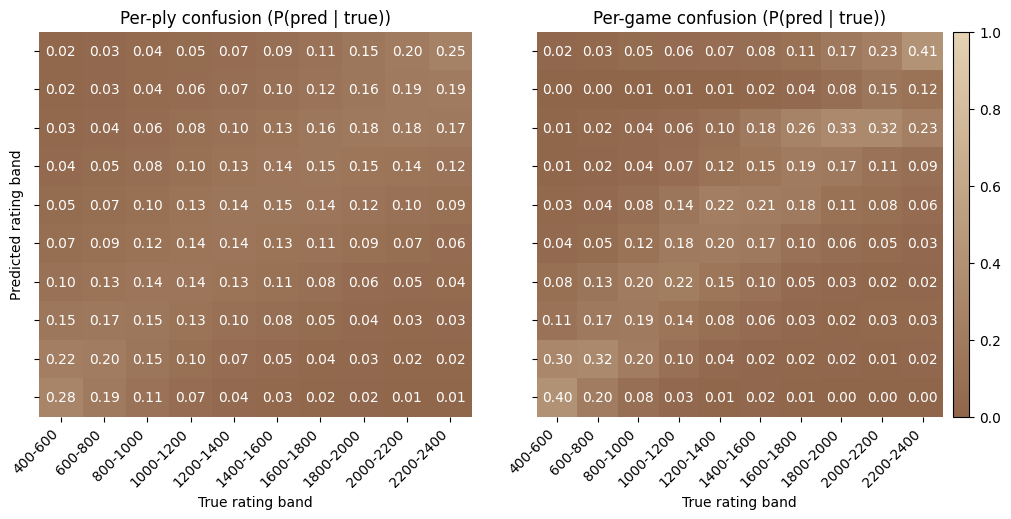

In [4]:
fig, axes = plot_band_confusion_heatmap(
    df_out_test,
    game_summary_test,
    band_labels=band_table_test["band_label"].tolist(),
)
plt.show()

In [5]:
df_out_real, game_summary_real, metrics_real, meta_real = evaluate_model_on_npz(
    npz_path=R_TEST_NPZ_PATH,
    ckpt_path=CKPT_PATH,
    batch_size=512,
    device=DEVICE,
    alpha=0.7,
    gamma=1.0,
    eps=1e-8,
)

print("=== Aggregate test metrics (real test shard) ===")
for k in sorted(metrics_real.keys()):
    print(f"{k}: {metrics_real[k]:.4f}")

band_table_real = compute_band_distribution_table(df_out_real, game_summary_real)
band_table_real.style.format({
    "ply_true_pct": "{:.3f}",
    "ply_pred_pct": "{:.3f}",
    "game_true_pct": "{:.3f}",
    "ply_pred_prob_pct": "{:.3f}",
})

=== Aggregate test metrics (real test shard) ===
avg_plies_per_game: 68.2289
game_post_band_accuracy: 0.2335
game_post_mae: 300.4776
game_reg_last_mae: 1523.9973
game_reg_mean_mae: 1524.0011
num_games: 9993.0000
num_plies: 681811.0000
ply_band_accuracy: 0.1801
ply_reg_mae: 1554.1012


,band_index,band_label,ply_true_pct,ply_pred_pct,game_true_pct,ply_pred_prob_pct
0,0,400-600,0.001,0.034,0.001,0.038
1,1,600-800,0.014,0.052,0.019,0.056
2,2,800-1000,0.051,0.060,0.061,0.075
3,3,1000-1200,0.100,0.094,0.111,0.099
4,4,1200-1400,0.158,0.131,0.164,0.117
5,5,1400-1600,0.196,0.142,0.197,0.131
6,6,1600-1800,0.216,0.121,0.206,0.134
7,7,1800-2000,0.171,0.156,0.159,0.135
8,8,2000-2200,0.077,0.060,0.068,0.110
9,9,2200-2400,0.015,0.149,0.013,0.105


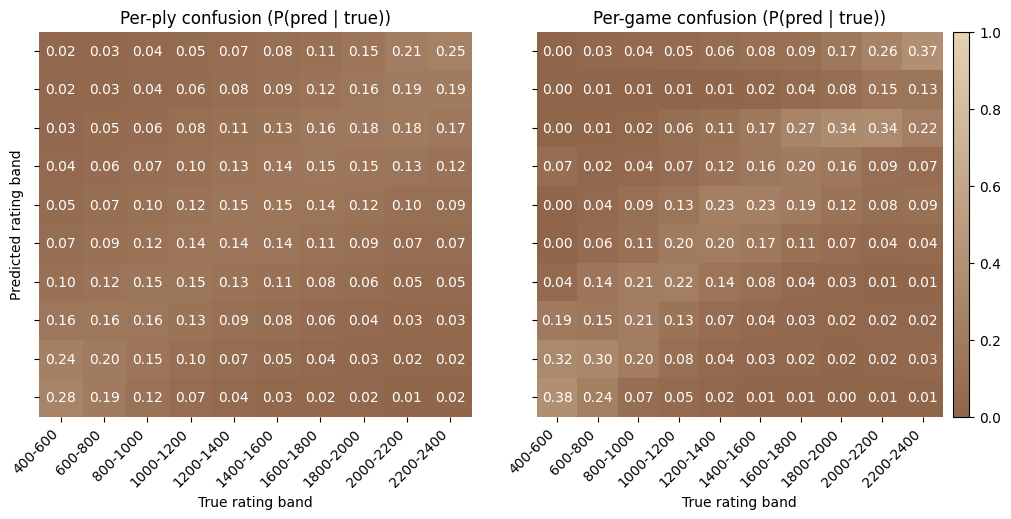

In [6]:
fig, axes = plot_band_confusion_heatmap(
    df_out_real,
    game_summary_real,
    band_labels=band_table_real["band_label"].tolist(),
)
plt.show()

In [7]:
df_out_gte, game_summary_gte, metrics_gte, meta_gte = evaluate_model_on_pgn(
    pgn_path=PGN_PATH,
    ckpt_path=CKPT_PATH,
    npz_path=NPZ_GTE,
    min_rating=400,
    max_rating=2400,
    num_bins=10,
    batch_size=64,
    device=DEVICE,
    alpha=0.7,
    gamma=1.0,
    eps=1e-8,
)

print("=== Metrics on gte.pgn ===")
for k in sorted(metrics_gte.keys()):
    print(f"{k:30s} {metrics_gte[k]:10.4f}")

Scanning games in gte.pgn: 1game [00:00, 37.72game/s]

=== Metrics on gte.pgn ===
avg_plies_per_game                70.0000
game_post_band_accuracy            0.0000
game_post_mae                    118.6361
game_reg_last_mae               1981.7945
game_reg_mean_mae               1981.7700
num_games                          1.0000
num_plies                         70.0000
ply_band_accuracy                  0.1143
ply_reg_mae                     1981.7700


In [8]:
# For gte.pgn we expect a single game, but we'll do this generically.
df_game = df_out_gte.sort_values("ply_idx").copy()
game_id = int(df_game["game_id"].iloc[0])

num_plies = len(df_game)
print(f"gte.pgn -> game_id = {game_id}, num_plies = {num_plies}")

df_game.head()

gte.pgn -> game_id = 0, num_plies = 70


,game_id,ply_idx,y_bin,y_elo,pred_bin,pred_rating,prob_400_600,prob_600_800,prob_800_1000,prob_1000_1200,prob_1200_1400,prob_1400_1600,prob_1600_1800,prob_1800_2000,prob_2000_2200,prob_2200_2400
0,0,0,7,1981.5,4,-0.074458,0.084941,0.093609,0.103352,0.111092,0.113672,0.102946,0.105127,0.099697,0.094668,0.090896
1,0,1,7,1981.5,8,-0.115297,0.015950,0.019223,0.027547,0.045196,0.078282,0.092475,0.140566,0.184913,0.209023,0.186825
2,0,2,7,1981.5,8,-0.134837,0.010028,0.012500,0.017982,0.035725,0.066038,0.091277,0.137186,0.189842,0.220898,0.218523
3,0,3,7,1981.5,9,-0.127802,0.011919,0.011870,0.012325,0.017808,0.031710,0.054074,0.085265,0.155711,0.236483,0.382834
4,0,4,7,1981.5,9,-0.155876,0.007844,0.006148,0.005527,0.009116,0.018828,0.041569,0.075655,0.156528,0.257222,0.421561


In [9]:
# Build PGN-derived metadata mapping (game_id, ply_idx) → {fen_pre, fen_post, move_uci}
ply_meta = build_ply_metadata_from_pgn(PGN_PATH)

# Choose which NPZ row to inspect (0 = first ply)
row_index = 16

show_npz_planes_grid_for_row(
    npz_path=NPZ_GTE,
    ply_meta=ply_meta,
    row_index=row_index,
    size=120,
    show_labels=True,
    regenerate_npz=True,
    pgn_path=PGN_PATH,
    pgn_to_npz_kwargs=dict(
        max_games=None,
        min_rating=400,
        max_rating=2400,
        num_bins=10,
    ),
)

Scanning games in gte.pgn: 1game [00:00, 45.45game/s]


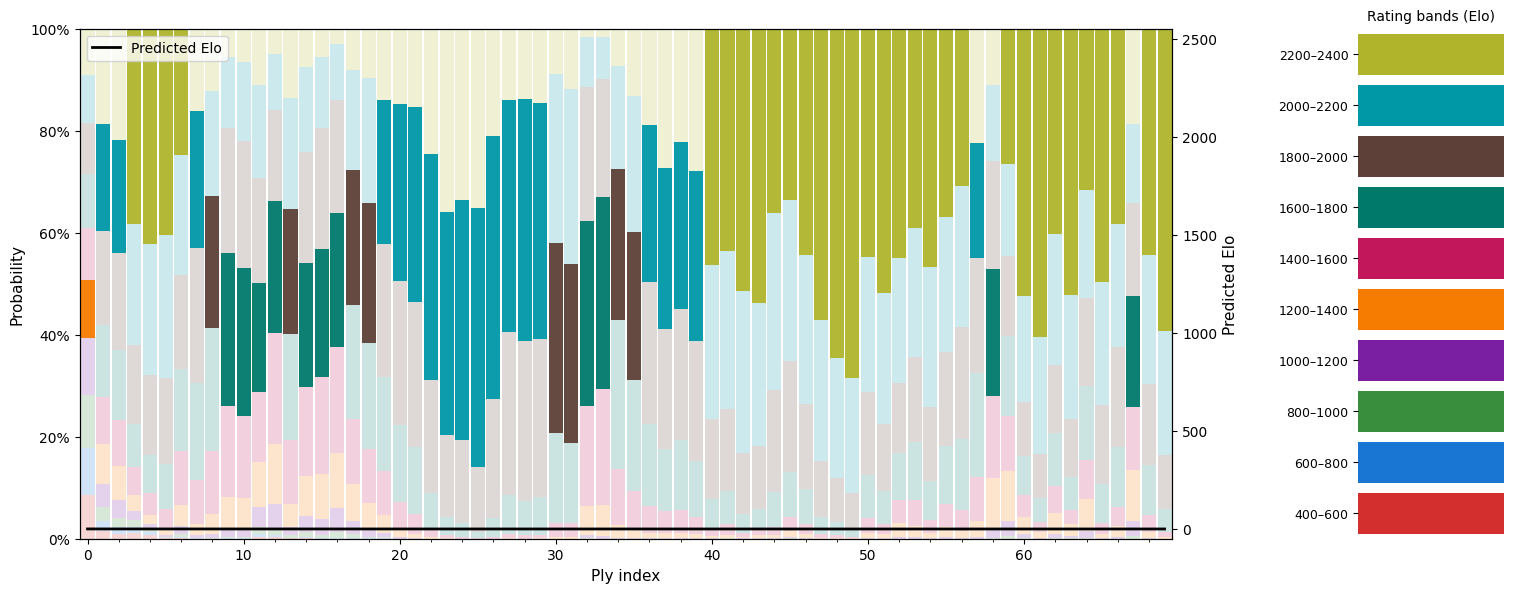

In [10]:
min_rating_gte = float(meta_gte["min_rating"]) # 0
max_rating_gte = float(meta_gte["max_rating"]) # 2500

_ = plot_ply_likelihoods_with_elo(
    df_game,
    min_rating=0,
    max_rating=2500,
)

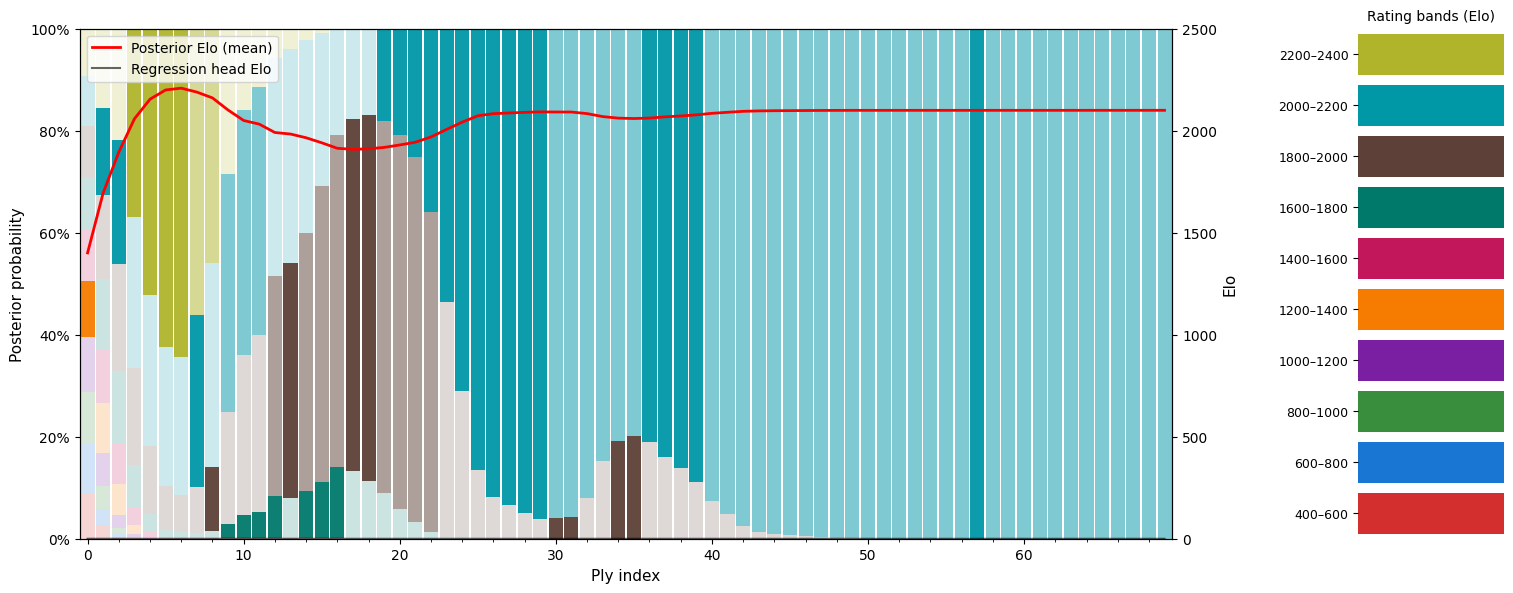

In [11]:
_ = plot_bayesian_posterior_with_elo_and_legend(
    df_game,
    alpha=0.7,
    gamma=1.0,
    eps=1e-8,
    min_rating=0,
    max_rating=2500,
)

In [12]:
moves_san: list[str] = []
with PGN_PATH.open("r", encoding="utf-8") as f:
    game = chess.pgn.read_game(f)
    board = game.board()
    for move in game.mainline_moves():
        moves_san.append(board.san(move))
        board.push(move)

game_result = game.headers.get("Result", "*")

OUT_ROOT = Path("plots/rym_inspect_conv")

# Clear it completely before regenerating anything
if OUT_ROOT.exists():
    shutil.rmtree(OUT_ROOT)

OUT_ROOT.mkdir(parents=True, exist_ok=True)
print(f"[clean] Reset {OUT_ROOT} (now empty)")

[clean] Reset plots\rym_inspect_conv (now empty)


In [13]:
save_board_frames_for_pgn(
    pgn_path=PGN_PATH,
    game_id=game_id,
    out_root=OUT_ROOT,
    boards_subdir="boards",
    size=320,
    prefix="frame",
)

save_dist_frames_for_game(
    df_game=df_game,
    out_root=OUT_ROOT,
    dist_subdir="dist",
    prefix="frame",
    move_labels=moves_san,
    game_result=game_result,
)

[boards] Wrote 211 board frames to plots\rym_inspect_conv\boards
[dist] Wrote 211 distribution frames to plots\rym_inspect_conv\dist


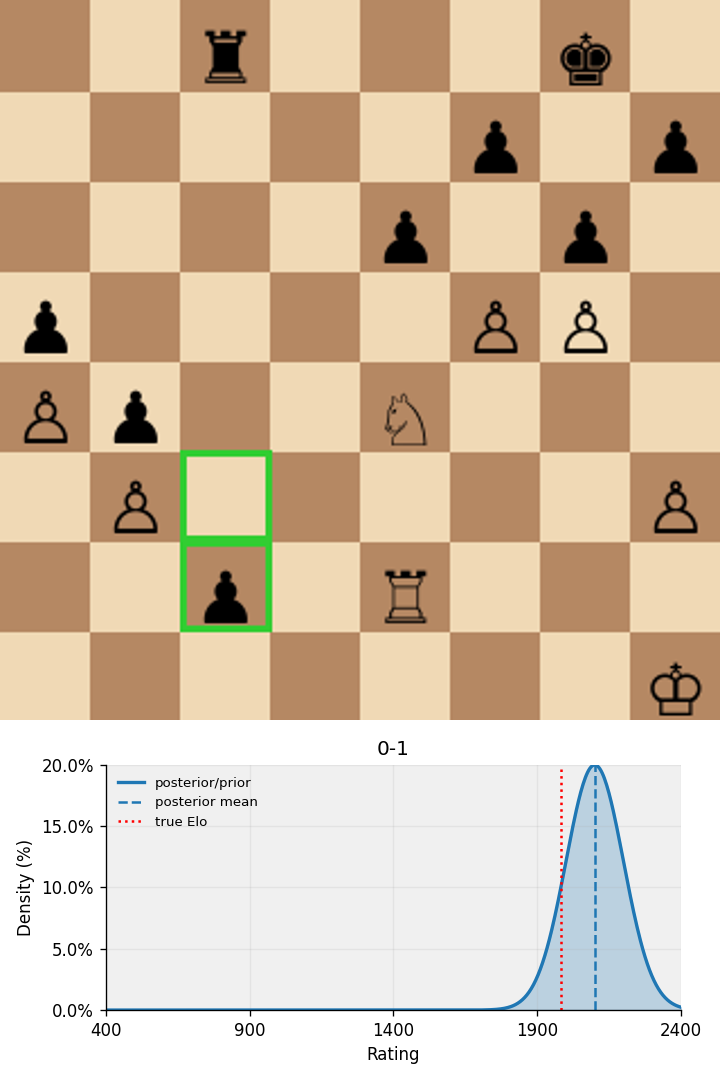

In [14]:
# 3) Stitch + replay
stitch_board_and_dist(
    root_dir=OUT_ROOT,
    boards_subdir="boards",
    dist_subdir="dist",
    out_subdir="combined",
    flatten_factor=1.0,
)

replay_images(OUT_ROOT / "combined", delay=0.5, display_width=640)